Dataset: 
- head of C.elegans worm with GCAMP6 expressed in neurons. 
- imaged with light-sheeet microscope (daoSPIM) from two orthogonal directions, at 45 deg to the worm body axis.
- original images are highly anisotropic in Z vs XY. Resampled in simpleITK for isotropic resolution.
- unsheared using simpleITK.
- views are roughly registered using a rigid transformation
- views do not fully overlap with each other (left side of view0 is not in view1)

Goals:
- fine-tune the registration using non-rigid methods.
- deconvolve using Richardson-Lucy method to obtain merged volume from the two views.

In [1]:
import SimpleITK as sitk
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import util
import registration_callbacks
import os

In [2]:
dirname_data = './datasets/2019-03-05/'

### Load the images

In [3]:
view0 = sitk.ReadImage(os.path.normpath(dirname_data + 'head_view0_cropped.mhd'))
view1 = sitk.ReadImage(os.path.normpath(dirname_data + 'head_view1_cropped.mhd'))

Voxel size, um: (0.14625, 0.14625, 0.14625)
View0 size, px: (762, 140, 177)
View1 size, px: (762, 140, 177)
(73.0, 2375.0)
(0.0, 2583.0)


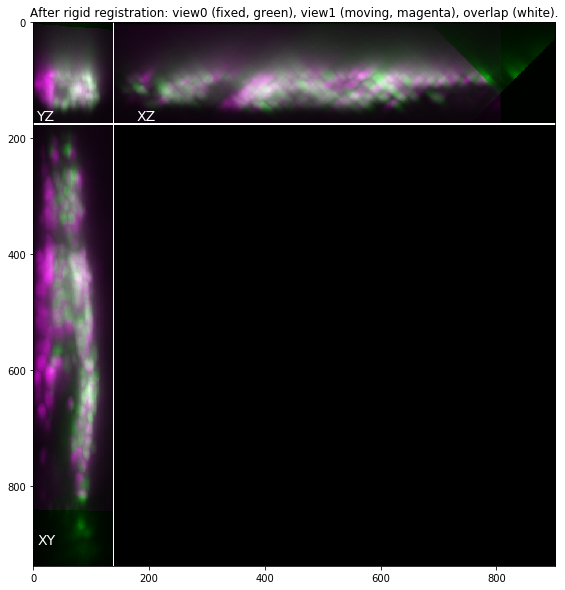

In [6]:
print(f"Voxel size, um: {view0.GetSpacing()}")

print(f"View0 size, px: {view0.GetSize()}")
print(f"View1 size, px: {view1.GetSize()}")

print(util.get_minmax(view0))
print(util.get_minmax(view1))

img_merge = util.merge_images_rgb(view0, view1)

fig = plt.figure(figsize=(10,10))
util.show_mips(img_merge, "After rigid registration: view0 (fixed, green), view1 (moving, magenta), overlap (white).")

In [ ]:
fixed_image = sitk.Cast(view0, sitk.sitkFloat32)
moving_image = sitk.Cast(view1, sitk.sitkFloat32)

### Non-rigid registration attempts

Registration docs [overview](https://simpleitk.readthedocs.io/en/master/registrationOverview.html)

FFD registration attempt based on [65_Registration_FFD](http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/65_Registration_FFD.html) notebook.

In [12]:
def bspline_intra_modal_registration(fixed_image, moving_image):
    registration_method = sitk.ImageRegistrationMethod()
    # Determine the number of BSpline control points using the physical spacing we want for the control grid. 
    grid_physical_spacing = [5.0, 5.0, 5.0] # A control point every 50mm
    image_physical_size = [size*spacing for size,spacing in zip(fixed_image.GetSize(), fixed_image.GetSpacing())]
    mesh_size = [int(image_size/grid_spacing + 0.5) \
                 for image_size,grid_spacing in zip(image_physical_size,grid_physical_spacing)]

    initial_transform = sitk.BSplineTransformInitializer(image1 = fixed_image, transformDomainMeshSize = mesh_size, order=3)    
    registration_method.SetInitialTransform(initial_transform)
        
    registration_method.SetMetricAsMeanSquares()
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.1)
    
    # Multi-resolution framework.            
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    registration_method.SetInterpolator(sitk.sitkLinear)
    registration_method.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-5, numberOfIterations=100)
    
    return registration_method.Execute(fixed_image, moving_image)

In [ ]:
final_transform = bspline_intra_modal_registration(fixed_image, moving_image)

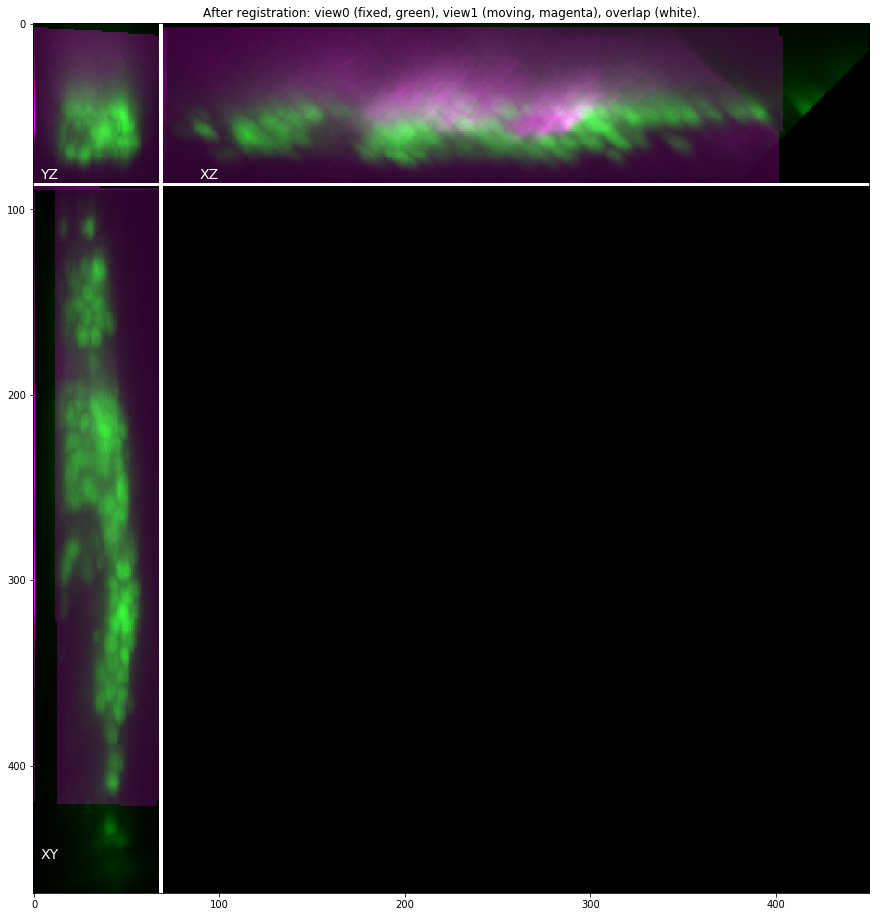

In [18]:
view1_registered = sitk.Resample(view1, view0, final_transform, sitk.sitkLinear, 0.0, view0.GetPixelID())

img_merge = util.merge_images_rgb(view0, view1_registered)

fig = plt.figure(figsize=(10,10))
util.show_mips(img_merge, "After FFD registration: view0 (fixed, green), view1 (moving, magenta), overlap (white).")

### Demons registration attempt

Demons registration attempt based on [66_Registration_Demons](http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/66_Registration_Demons.html) notebook and from these [examples](https://simpleitk.org/SPIE2019_COURSE/05_advanced_registration.html). 

In [8]:
def demons_registration(fixed_image, moving_image):
    registration_method = sitk.ImageRegistrationMethod()

    # Create initial identity transformation.
    transform_to_displacment_field_filter = sitk.TransformToDisplacementFieldFilter()
    transform_to_displacment_field_filter.SetReferenceImage(fixed_image)
    # The image returned from the initial_transform_filter is transferred to the transform and cleared out.
    initial_transform = sitk.DisplacementFieldTransform(transform_to_displacment_field_filter.Execute(sitk.Transform()))
    
    # Regularization (update field - viscous, total field - elastic).
    initial_transform.SetSmoothingGaussianOnUpdate(varianceForUpdateField=0.0, varianceForTotalField=2.0) 
    
    registration_method.SetInitialTransform(initial_transform)

    registration_method.SetMetricAsDemons(10) #intensities are equal if the difference is less than 10HU
        
    # Multi-resolution framework.            
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[8,4,0])    

    registration_method.SetInterpolator(sitk.sitkLinear)
    # If you have time, run this code as is, otherwise switch to the gradient descent optimizer    
    #registration_method.SetOptimizerAsConjugateGradientLineSearch(learningRate=1.0, numberOfIterations=20, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=20, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()
 
    return registration_method.Execute(fixed_image, moving_image)

In [9]:
tx = demons_registration(fixed_image, moving_image)

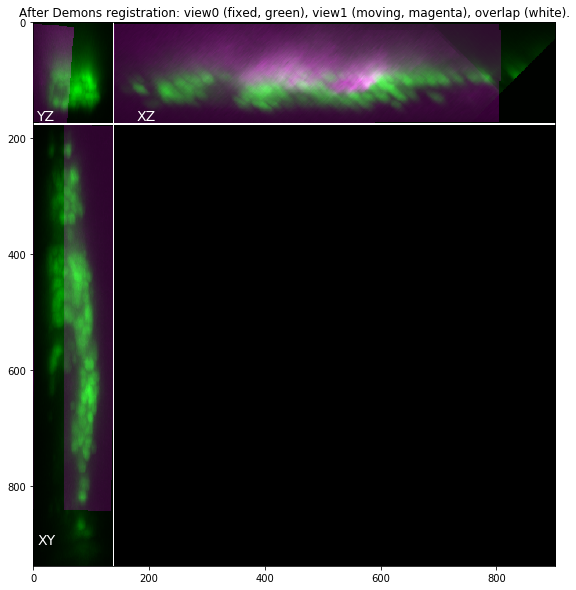

In [11]:
view1_registered = sitk.Resample(view1, view0, tx, sitk.sitkLinear, 0.0, view0.GetPixelID())

img_merge = util.merge_images_rgb(view0, view1_registered)

fig = plt.figure(figsize=(10,10))
util.show_mips(img_merge, "After Demons registration: view0 (fixed, green), view1 (moving, magenta), overlap (white).")

In [ ]:
%load_ext watermark
# Print dependencies for binder
%watermark -v -m -p SimpleITK, numpy, matplotlib, os, scipy